# AI 주가 예측 프로그램 만들기
테슬라 주식 예측 - 잘되면 진짜 사야지...!

필요 모듈 임포트 및 시계열 데이터 준비

장마감 시가 - close column에 있는 데이터 이용

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# Time Series 생성
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/TSLA (1).csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2016-01-04    44.681999
2016-01-05    44.686001
2016-01-06    43.807999
2016-01-07    43.130001
2016-01-08    42.200001
Name: Close, dtype: float64

## 각종 전처리 실시
- 결측치 처리
- 로그 변환

Text(0.5, 1.0, 'TESLA STOCK PRICE')

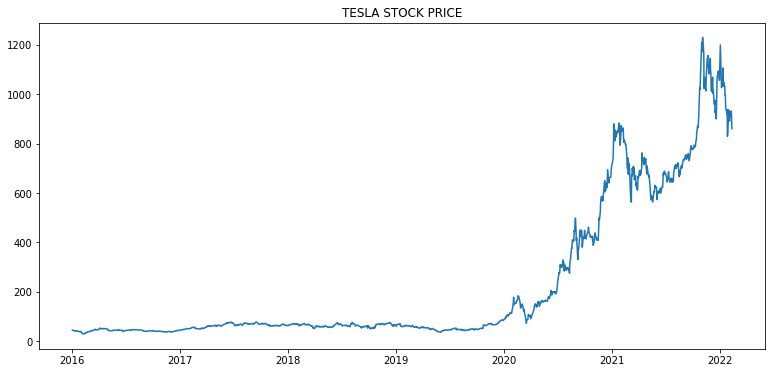

In [2]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6    # matlab 차트의 기본 크기를 13, 6으로 지정해 줍니다.

# 시계열(time series) 데이터를 차트로 그려 봅시다. 특별히 더 가공하지 않아도 잘 그려집니다.
plt.plot(ts)
plt.title("TESLA STOCK PRICE")

In [3]:
#결측치 유무 확인
ts[ts.isna()]  # 시계열(Time Series)에서 결측치가 있는 부분만 Series로 출력합니다.

Series([], Name: Close, dtype: float64)

결측치 없음 


있는 경우
결측치 삭제, 혹은 보간(interploate) 대입

Series([], Name: Close, dtype: float64)


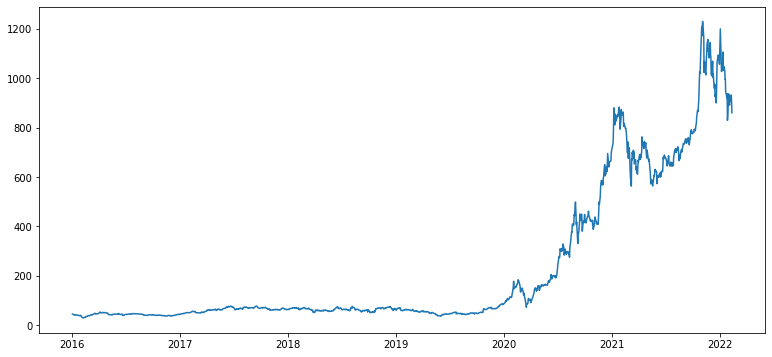

In [4]:
# 결측치가 있다면 이를 보간합니다. 보간 기준은 time을 선택합니다. 
ts=ts.interpolate(method='time')

# 보간 이후 결측치(NaN) 유무를 다시 확인합니다.
print(ts[ts.isna()])

# 다시 그래프를 확인해봅시다!
plt.plot(ts)

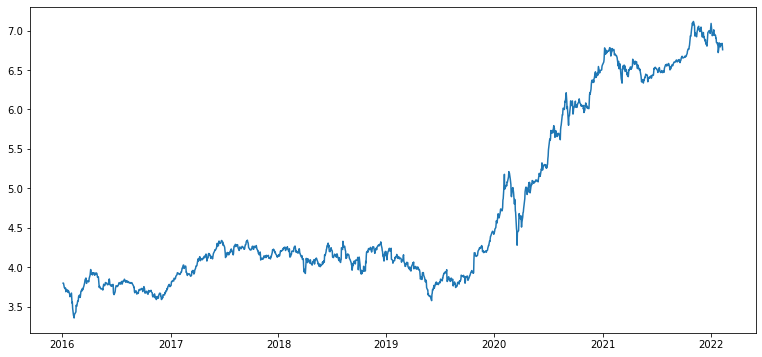

In [5]:
ts_log = np.log(ts)
plt.plot(ts_log)

값의 크기가 달라지고 분포는 그대로

## stationary data 판단함수 만들기

In [6]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    
print('슝=3')

슝=3


In [7]:
print("<Before log processing>")
augmented_dickey_fuller_test(ts)
print("\n\n\n")
print("<After log processing>")
augmented_dickey_fuller_test(ts_log)

<Before log processing>
Results of Dickey-Fuller Test:
Test Statistic                   -0.298080
p-value                           0.925776
#Lags Used                       24.000000
Number of Observations Used    1515.000000
Critical Value (1%)              -3.434674
Critical Value (5%)              -2.863450
Critical Value (10%)             -2.567787
dtype: float64




<After log processing>
Results of Dickey-Fuller Test:
Test Statistic                    0.387813
p-value                           0.981033
#Lags Used                        0.000000
Number of Observations Used    1539.000000
Critical Value (1%)              -3.434606
Critical Value (5%)              -2.863420
Critical Value (10%)             -2.567771
dtype: float64


로그 변환 후 오히려 더 불안정해 진 것을 볼 수 있다

## 이동 평균 구하는 함수 작성

In [8]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
print('슝=3')

슝=3


## 그래프 분석

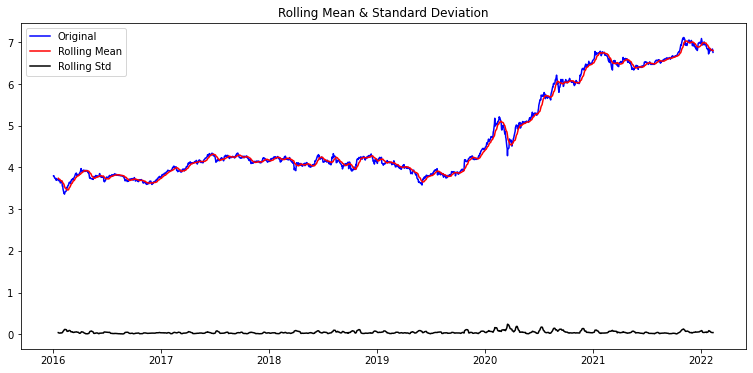

Results of Dickey-Fuller Test:
Test Statistic                    0.387813
p-value                           0.981033
#Lags Used                        0.000000
Number of Observations Used    1539.000000
Critical Value (1%)              -3.434606
Critical Value (5%)              -2.863420
Critical Value (10%)             -2.567771
dtype: float64


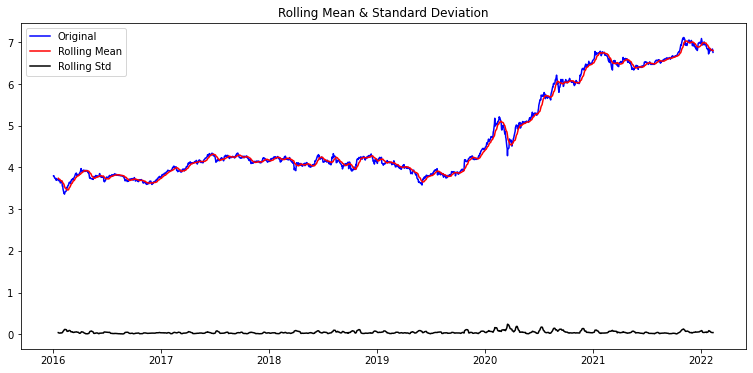

Results of Dickey-Fuller Test:
Test Statistic                    0.387813
p-value                           0.981033
#Lags Used                        0.000000
Number of Observations Used    1539.000000
Critical Value (1%)              -3.434606
Critical Value (5%)              -2.863420
Critical Value (10%)             -2.567771
dtype: float64


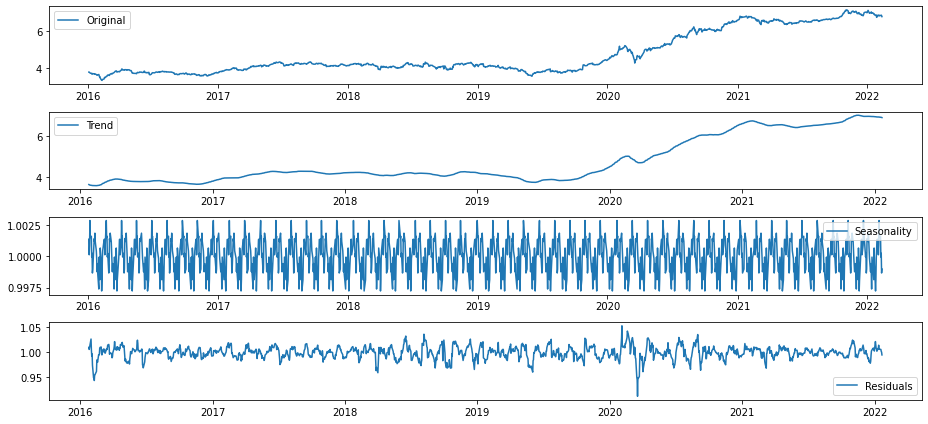

In [9]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

## Residual 안정성 확인

In [10]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -1.187939e+01
p-value                        6.229491e-22
#Lags Used                     1.800000e+01
Number of Observations Used    1.491000e+03
Critical Value (1%)           -3.434743e+00
Critical Value (5%)           -2.863480e+00
Critical Value (10%)          -2.567803e+00
dtype: float64


## 학습, 테스트 데이터 셋 분리

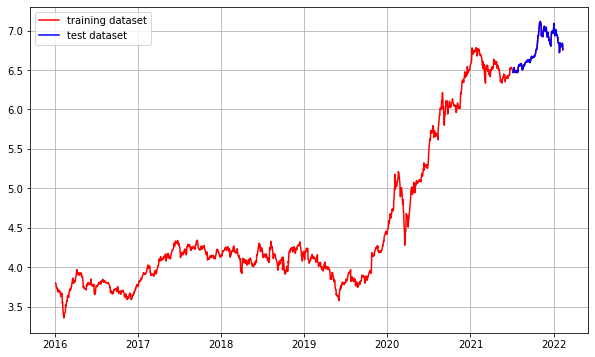

In [11]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

## 적정 ARIMA 모수 찾기
- ACF, PACF 그려보기 -> p,q 구하기
- 차분 안정성 확인 -> d 구하기

/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


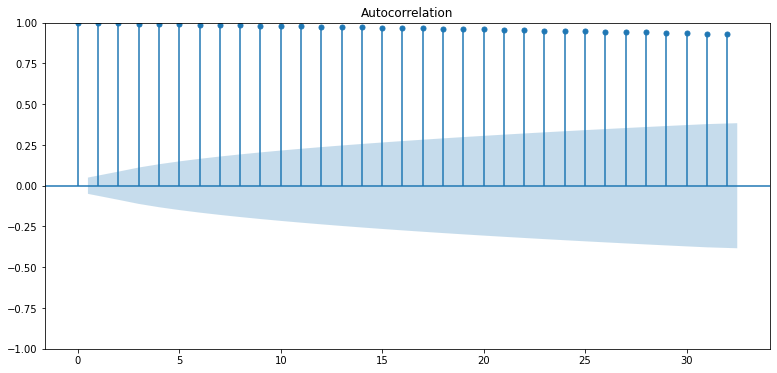

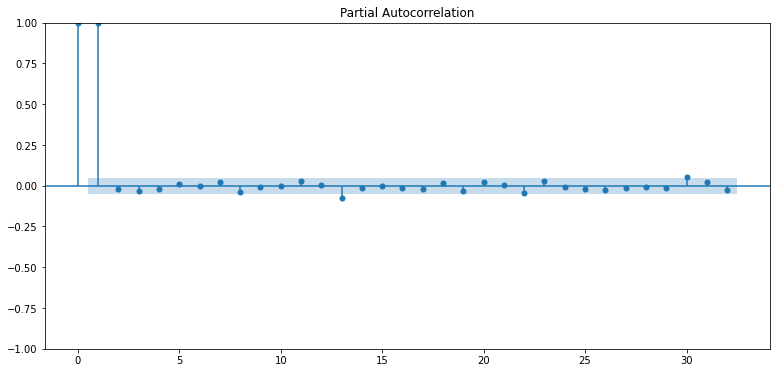

In [12]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

ACF를 통해 MA 모델의 시차 q를 결정하고, PACF를 통해 AR 모델의 시차 p를 결정할 수 있음


해당 PACF 그래프를 보면 p = 1 이상일땐 상관도가 0에 가까우므로, p = 0, 1로 설정

반면 ACF는 점차적으로 감소하고 있어서 AR(1) 모델에 유사한 형태를 보이고 있다. q에 대해서는 적합한 값이 없어 보인다. MA를 고려할 필요가 없다면 q=0에서부터 하나씩 차례로 해보자

Results of Dickey-Fuller Test:
Test Statistic                  -21.081405
p-value                           0.000000
#Lags Used                        2.000000
Number of Observations Used    1536.000000
Critical Value (1%)              -3.434614
Critical Value (5%)              -2.863424
Critical Value (10%)             -2.567773
dtype: float64


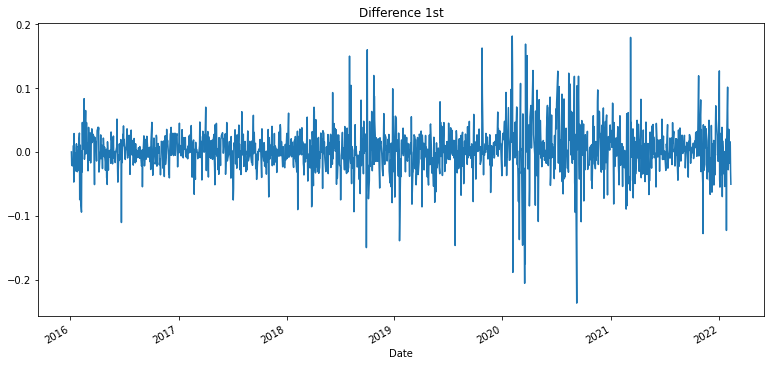

In [13]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)


Results of Dickey-Fuller Test:
Test Statistic                -1.371329e+01
p-value                        1.226192e-25
#Lags Used                     2.300000e+01
Number of Observations Used    1.514000e+03
Critical Value (1%)           -3.434677e+00
Critical Value (5%)           -2.863451e+00
Critical Value (10%)          -2.567787e+00
dtype: float64


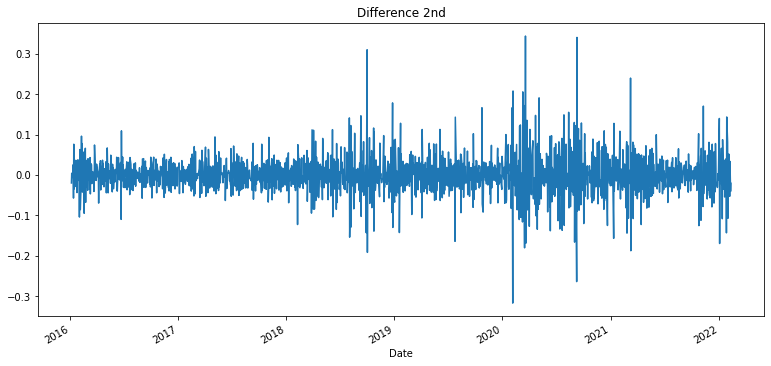

In [14]:
# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

1차 차분시 p-value가 더 낮으므로 d = 1

## model ARIMA train


/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1386
Model:                 ARIMA(1, 2, 1)   Log Likelihood                2616.224
Date:                Mon, 14 Feb 2022   AIC                          -5226.448
Time:                        13:43:12   BIC                          -5210.750
Sample:                             0   HQIC                         -5220.576
                               - 1386                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0074      0.018     -0.414      0.679      -0.042       0.027
ma.L1         -0.9964      0.002   -502.341      0.000      -1.000      -0.992
sigma2         0.0013   2.61e-05     50.966      0.0

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


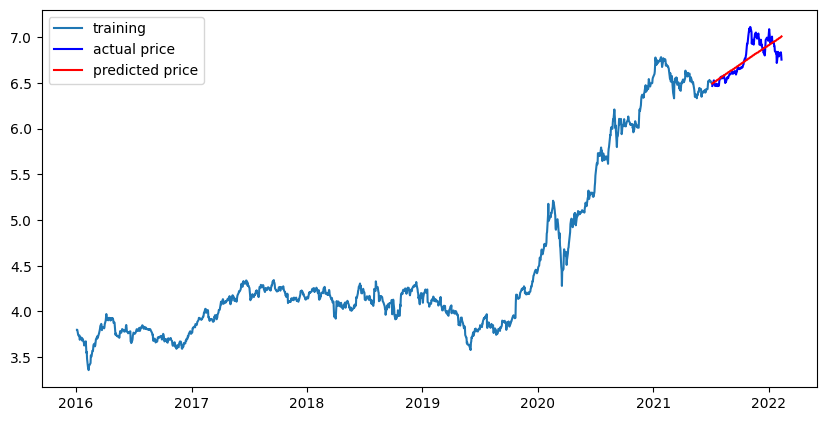

In [22]:
from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(1, 2, 1))  #p,q,d = 1,2,1
fitted_m = model.fit() 

print(fitted_m.summary())

# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

시계열 데이터를 로그 변환하여 사용했으므로 다시 지수 변환해야 정확한 오차를 계산할 수 있다. np.exp()를 통해 전부 원본 스케일로 돌린 후 MSE, MAE,RMSE, MAPE 계산

In [23]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  13602.027853337058
MAE:  82.22577897790076
RMSE:  116.62773192228792
MAPE: 8.47%


# 다른 주식도 해보자!
- 아마존
- 애플


# AMZN - amazon

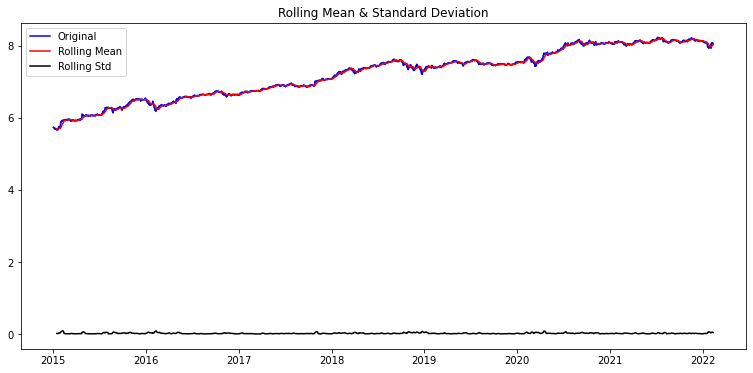

Results of Dickey-Fuller Test:
Test Statistic                   -2.346997
p-value                           0.157258
#Lags Used                       10.000000
Number of Observations Used    1781.000000
Critical Value (1%)              -3.434027
Critical Value (5%)              -2.863164
Critical Value (10%)             -2.567635
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -1.219030e+01
p-value                        1.290382e-22
#Lags Used                     2.400000e+01
Number of Observations Used    1.737000e+03
Critical Value (1%)           -3.434120e+00
Critical Value (5%)           -2.863205e+00
Critical Value (10%)          -2.567657e+00
dtype: float64


/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


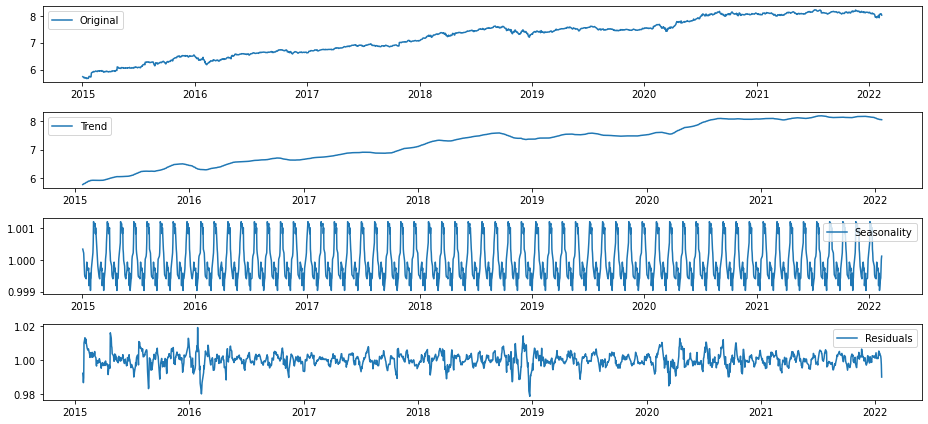

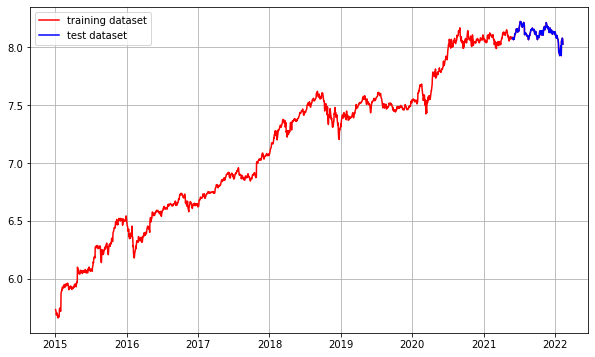

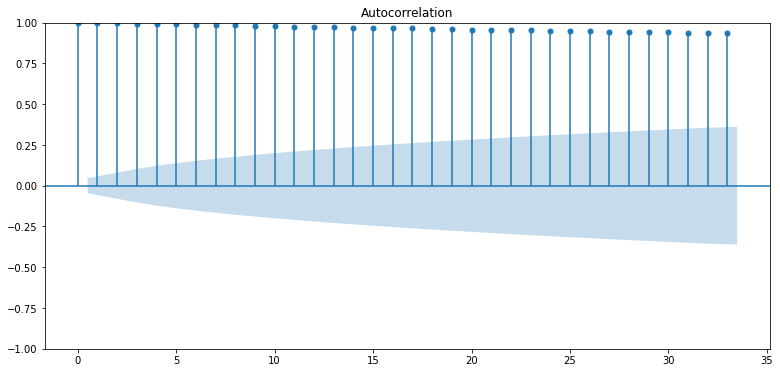

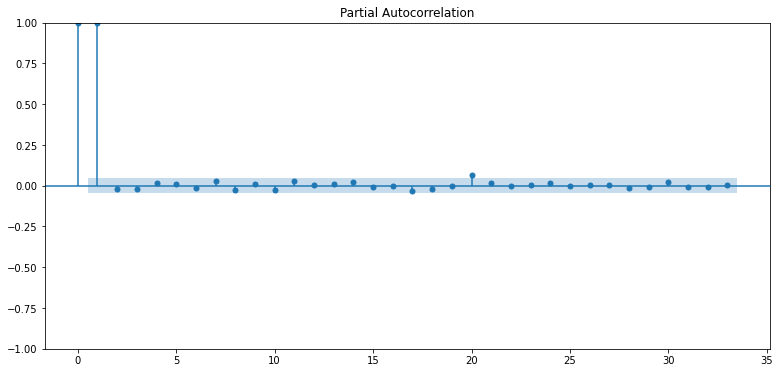

Results of Dickey-Fuller Test:
Test Statistic                -1.394569e+01
p-value                        4.802126e-26
#Lags Used                     9.000000e+00
Number of Observations Used    1.781000e+03
Critical Value (1%)           -3.434027e+00
Critical Value (5%)           -2.863164e+00
Critical Value (10%)          -2.567635e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -1.409116e+01
p-value                        2.720116e-26
#Lags Used                     2.500000e+01
Number of Observations Used    1.764000e+03
Critical Value (1%)           -3.434062e+00
Critical Value (5%)           -2.863180e+00
Critical Value (10%)          -2.567643e+00
dtype: float64


/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1612
Model:                 ARIMA(1, 2, 1)   Log Likelihood                4079.663
Date:                Mon, 14 Feb 2022   AIC                          -8153.326
Time:                        13:54:42   BIC                          -8137.174
Sample:                             0   HQIC                         -8147.330
                               - 1612                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0230      0.018     -1.315      0.188      -0.057       0.011
ma.L1         -1.0000      0.087    -11.490      0.000      -1.171      -0.829
sigma2         0.0004   3.26e-05     11.262      0.0

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


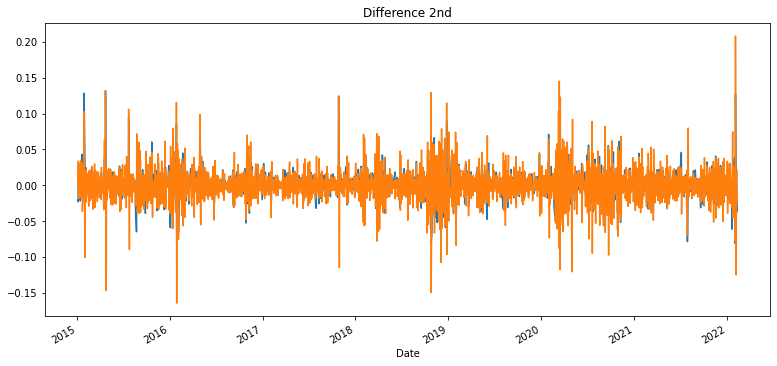

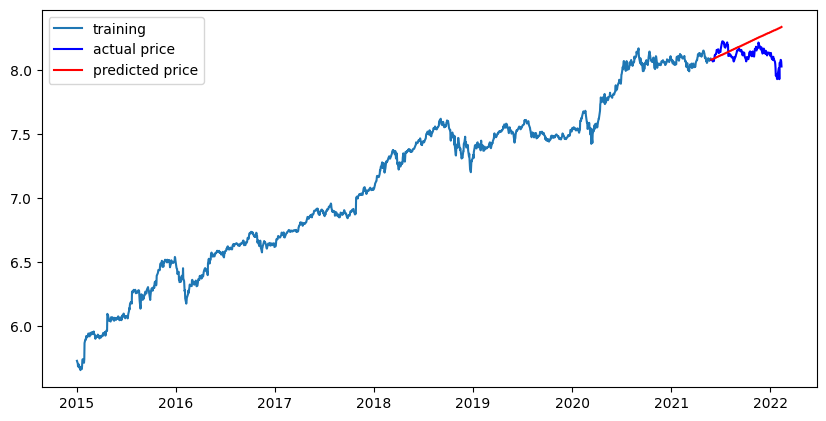

MSE:  246872.42029020994
MAE:  386.8176270602571
RMSE:  496.86257686629
MAPE: 11.87%


In [27]:
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/AMZN.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

# 결측치 처리
ts = ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.

# 로그 변환 시도 
ts_log = np.log(ts)
plt.plot(ts_log)

# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=10) #원래 12

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30)  

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()


from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()


# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:] 
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:] 
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)


from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(1, 2, 1))   
fitted_m = model.fit() 

print(fitted_m.summary())



# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()


from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

# NFLX - Netflix

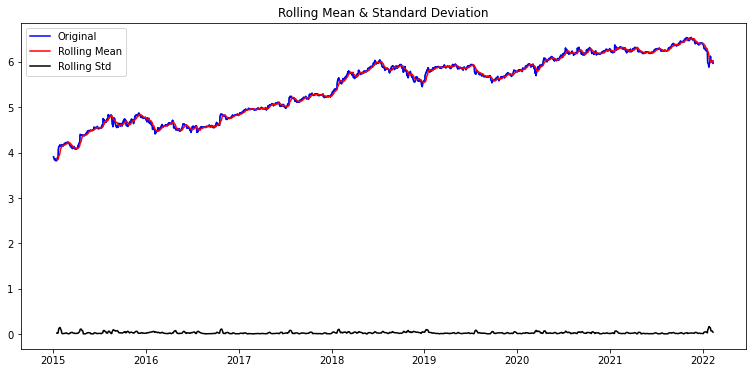

Results of Dickey-Fuller Test:
Test Statistic                   -2.375912
p-value                           0.148651
#Lags Used                        5.000000
Number of Observations Used    1786.000000
Critical Value (1%)              -3.434017
Critical Value (5%)              -2.863160
Critical Value (10%)             -2.567632
dtype: float64


/opt/conda/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:926: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


Results of Dickey-Fuller Test:
Test Statistic                         NaN
p-value                                NaN
#Lags Used                        0.000000
Number of Observations Used    1791.000000
Critical Value (1%)              -3.434006
Critical Value (5%)              -2.863155
Critical Value (10%)             -2.567630
dtype: float64


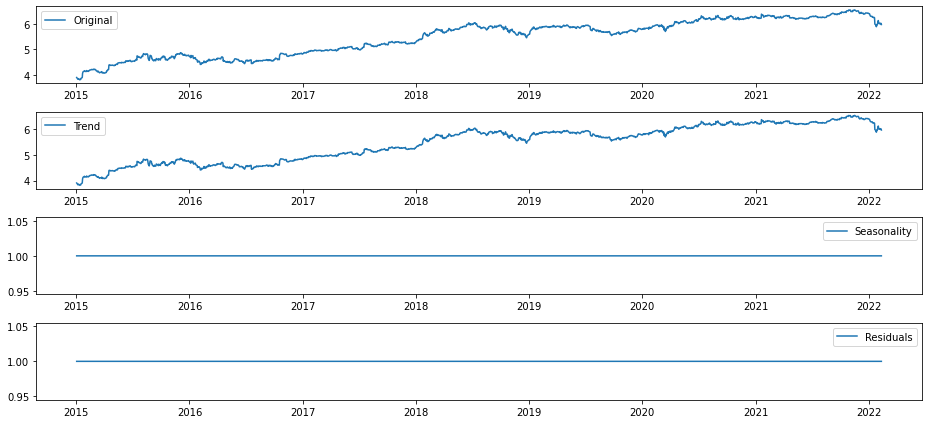

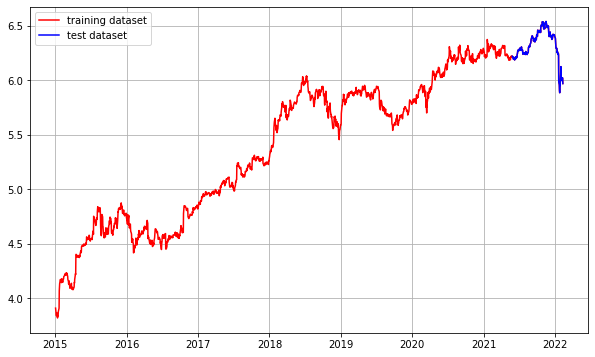

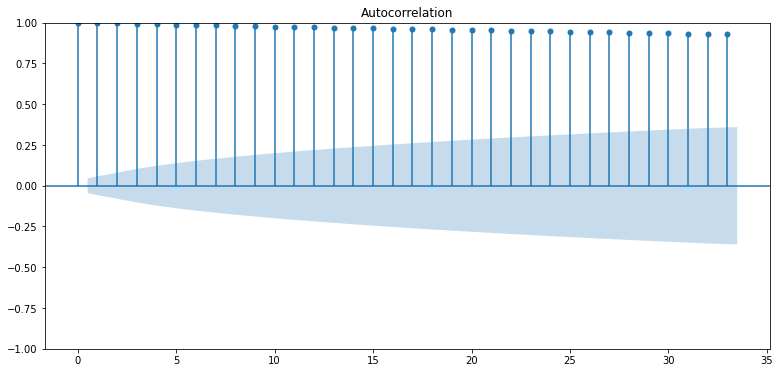

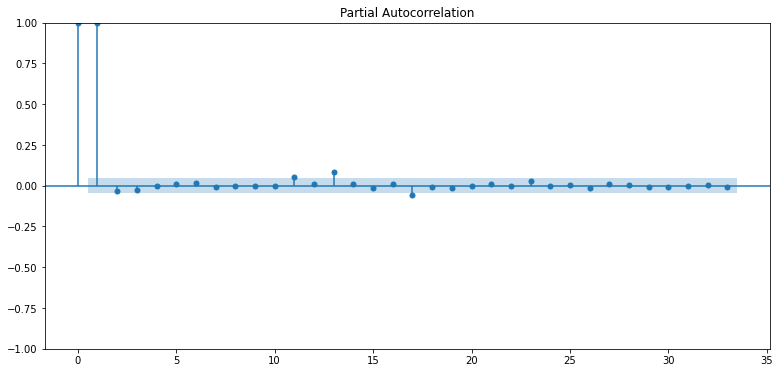

Results of Dickey-Fuller Test:
Test Statistic                  -19.824466
p-value                           0.000000
#Lags Used                        4.000000
Number of Observations Used    1786.000000
Critical Value (1%)              -3.434017
Critical Value (5%)              -2.863160
Critical Value (10%)             -2.567632
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -1.468081e+01
p-value                        3.158314e-27
#Lags Used                     2.300000e+01
Number of Observations Used    1.766000e+03
Critical Value (1%)           -3.434058e+00
Critical Value (5%)           -2.863178e+00
Critical Value (10%)          -2.567642e+00
dtype: float64


/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retva

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1612
Model:                 ARIMA(1, 2, 1)   Log Likelihood                3560.059
Date:                Mon, 14 Feb 2022   AIC                          -7114.117
Time:                        13:55:51   BIC                          -7097.965
Sample:                             0   HQIC                         -7108.121
                               - 1612                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0303      0.022     -1.405      0.160      -0.072       0.012
ma.L1         -1.0000      0.127     -7.869      0.000      -1.249      -0.751
sigma2         0.0007   8.91e-05      7.853      0.0

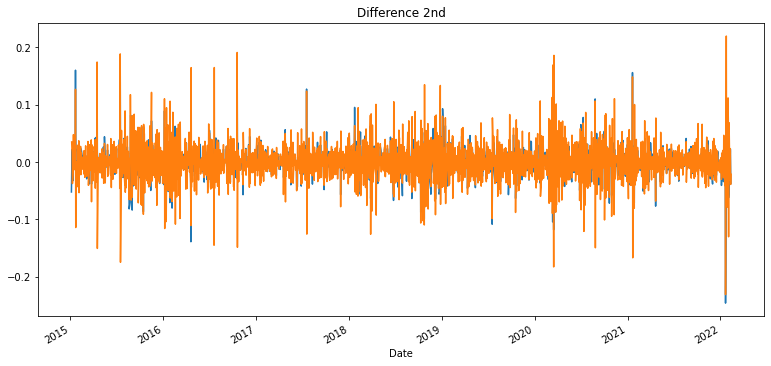

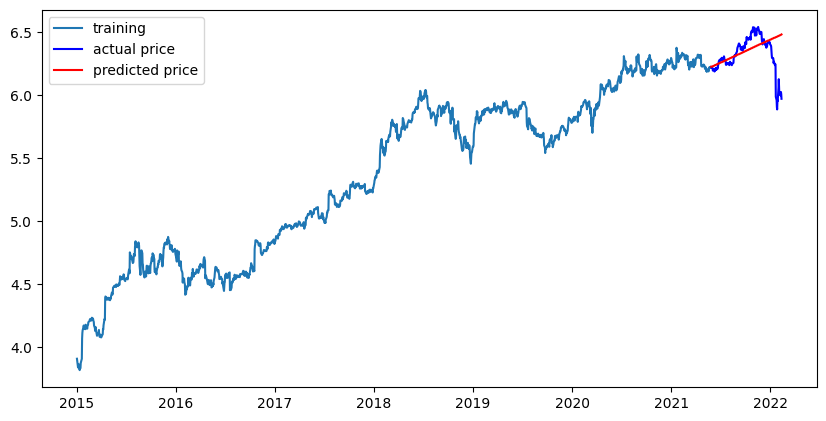

MSE:  7277.974686816837
MAE:  53.70824389998469
RMSE:  85.3110466869141
MAPE: 10.83%


In [30]:
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/NFLX.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

# 결측치 처리
ts = ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.

# 로그 변환 시도 
ts_log = np.log(ts)
plt.plot(ts_log)

# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=10) #원래 12

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 1)  

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()


from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()


# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:] 
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:] 
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)


from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(1, 2, 1))   
fitted_m = model.fit() 

print(fitted_m.summary())



# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()


from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

# Review

통계적인 이론을 이해하는 것이 굉장히 어려웠다.


처음에 정확도가 굉장히 낮게 나와서 당황했는데, 알고보니 데이터를 1년치 데이터만 가져와서라는 것을 깨닫고 데이터의 범위를 늘리니 15% 미만으로 잘 수렴하기 시작했다. 자세한 예측(1년치 데이터를 가지고 국소 범위 예측)보다 보다 포괄적인 예측을 더 잘 수행한다는 것을 알게 되었다.(다년간의 데이터로 내후년도의 경향성 예측)

실제로 내가 관심있는 종목들에 대입해서 예측을 해보니 그것이 나름대로 재미있었다. 보다 발전시켜 실제 주식 예측 모델을 구현해보고자 한다.